# NER for constructing KG

In [ ]:
!pip install spacy datasets scikit-learn
!python -m spacy download en_core_web_sm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 11.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is 

## EDA and preprocessing CoNLLu04


In this experiment will be used [CoNLLU04 dataset](https://huggingface.co/datasets/DFKI-SLT/conll04) which contains extracted named entities (ORG, LOC, PER, MISC), their relations and corresponding texts. The original dataset can be found [here](https://cogcomp.seas.upenn.edu/page/resource_view/43)

In [16]:
!pip install spacy datasets scikit-learn
!python -m spacy download en_core_web_sm
!pip install sklearn_crfsuite

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 90.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load(

In [17]:
from datasets import load_dataset
dataset = load_dataset("DFKI-SLT/conll04")

README.md:   0%|          | 0.00/5.21k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/118k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/40.5k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/46.6k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/922 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/231 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/288 [00:00<?, ? examples/s]

The dataset has already contained data for validation and testing. Let's convert all JSON data in DataFrame.

In [18]:
df_train = dataset["train"].to_pandas()
df_val = dataset["validation"].to_pandas()
df_test = dataset["test"].to_pandas()
df_train.head()

,entities,tokens,relations,orig_id
0,"[{'end': 5, 'start': 4, 'type': 'Loc'}, {'end'...","[Newspaper, `, Explains, ', U.S., Interests, S...","[{'head': 2, 'tail': 1, 'type': 'OrgBased_In'}]",3255
1,"[{'end': 26, 'start': 22, 'type': 'Other'}, {'...","[`, `, If, it, does, not, snow, ,, and, a, lot...","[{'head': 3, 'tail': 4, 'type': 'Work_For'}]",95
2,"[{'end': 21, 'start': 19, 'type': 'Other'}, {'...","[The, self-propelled, rig, Avco, 5, was, heade...","[{'head': 2, 'tail': 1, 'type': 'Located_In'}]",2447
3,"[{'end': 2, 'start': 0, 'type': 'Peop'}, {'end...","[Annie, Oakley, ,, also, known, as, Little, Mi...","[{'head': 0, 'tail': 3, 'type': 'Live_In'}, {'...",5284
4,"[{'end': 1, 'start': 0, 'type': 'Peop'}, {'end...","[Penry, raped, Pamela, Moseley, Carpenter, on,...","[{'head': 3, 'tail': 4, 'type': 'Located_In'}]",210


The dataset does not contain NaNs, all columns (instead of unique id) are of object data type.

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 922 entries, 0 to 921
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   entities   922 non-null    object
 1   tokens     922 non-null    object
 2   relations  922 non-null    object
 3   orig_id    922 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 28.9+ KB


Let's provide basic statistics

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import spacy
nlp = spacy.load("en_core_web_sm")

In [6]:
print("Training samples:", len(df_train))
print("Validation samples:", len(df_val))
print("Test samples:", len(df_test))

Training samples: 922
Validation samples: 231
Test samples: 288


#### Texts and tokens

In [7]:
df_train["texts"] = df_train["tokens"].apply(lambda x: " ".join(x))
df_val["texts"] = df_val["tokens"].apply(lambda x: " ".join(x))
df_test["texts"] = df_test["tokens"].apply(lambda x: " ".join(x))
df_train.head()

,entities,tokens,relations,orig_id,texts
0,"[{'end': 5, 'start': 4, 'type': 'Loc'}, {'end'...","[Newspaper, `, Explains, ', U.S., Interests, S...","[{'head': 2, 'tail': 1, 'type': 'OrgBased_In'}]",3255,Newspaper ` Explains ' U.S. Interests Section ...
1,"[{'end': 26, 'start': 22, 'type': 'Other'}, {'...","[`, `, If, it, does, not, snow, ,, and, a, lot...","[{'head': 3, 'tail': 4, 'type': 'Work_For'}]",95,"` ` If it does not snow , and a lot , within t..."
2,"[{'end': 21, 'start': 19, 'type': 'Other'}, {'...","[The, self-propelled, rig, Avco, 5, was, heade...","[{'head': 2, 'tail': 1, 'type': 'Located_In'}]",2447,The self-propelled rig Avco 5 was headed to sh...
3,"[{'end': 2, 'start': 0, 'type': 'Peop'}, {'end...","[Annie, Oakley, ,, also, known, as, Little, Mi...","[{'head': 0, 'tail': 3, 'type': 'Live_In'}, {'...",5284,"Annie Oakley , also known as Little Miss Sure ..."
4,"[{'end': 1, 'start': 0, 'type': 'Peop'}, {'end...","[Penry, raped, Pamela, Moseley, Carpenter, on,...","[{'head': 3, 'tail': 4, 'type': 'Located_In'}]",210,Penry raped Pamela Moseley Carpenter on Oct. 1...


Examples of texts

In [8]:
for i in df_train['texts'].head(5):
  print(i)

Newspaper ` Explains ' U.S. Interests Section Events FL1402001894 Havana Radio Reloj Network in Spanish 2100 GMT 13 Feb 94
` ` If it does not snow , and a lot , within this month we will have no water to submerge 150 , 000 hectares ( 370 , 500 acres ) of rice , ' ' said Bruno Pusterla , a top official of the Italian Agricultural Confederation .
The self-propelled rig Avco 5 was headed to shore with 14 people aboard early Monday when it capsized about 20 miles off the Louisiana coast , near Morgan City , Lifa said.
Annie Oakley , also known as Little Miss Sure Shot , was born Phoebe Ann Moses in Willowdell , Darke County , in 1860 .
Penry raped Pamela Moseley Carpenter on Oct. 15 , 1979 , in Livingston , Texas , then stabbed her to death .


Plot token count distribution

Total Tokens: 26525
Average Tokens Per Row: 28.77


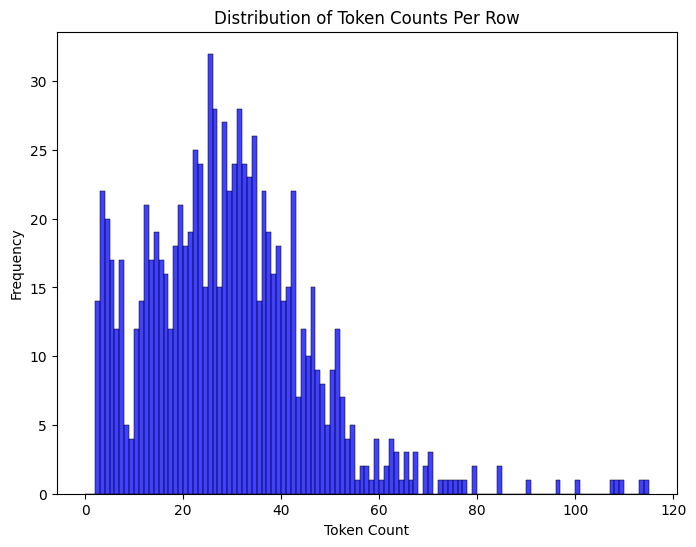

In [9]:
token_counts = [len(tokens) for tokens in df_train['tokens']]
total_tokens = sum(token_counts)
average_token_length = sum(token_counts) / len(token_counts)

print(f"Total Tokens: {total_tokens}")
print(f"Average Tokens Per Row: {average_token_length:.2f}")

plt.figure(figsize=(8, 6))
sns.histplot(token_counts, bins=range(0, max(token_counts) + 2), kde=False, color='blue')
plt.title('Distribution of Token Counts Per Row')
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.show()

Total Characters: 143962
Average Characters Per Row: 156.14


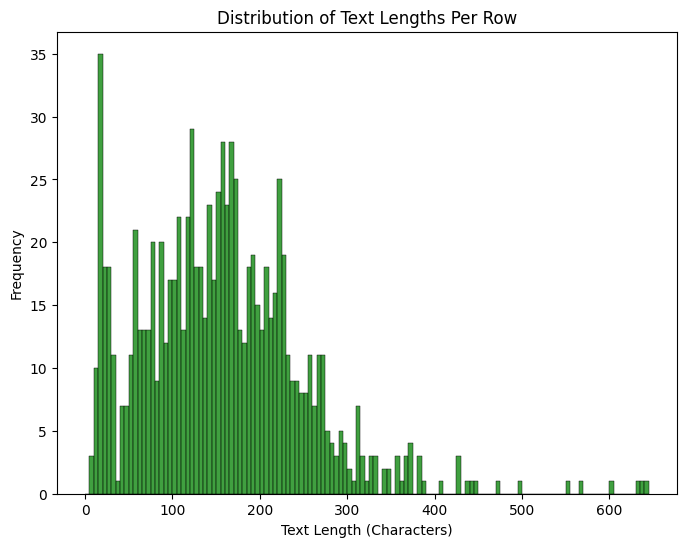

In [10]:
text_lengths = [len(text) for text in df_train['texts']]  # List of text lengths per row
total_text_length = sum(text_lengths)  # Total characters across all rows
average_text_length = sum(text_lengths) / len(text_lengths)  # Average characters per row

print(f"Total Characters: {total_text_length}")
print(f"Average Characters Per Row: {average_text_length:.2f}")

# Plot text length distribution
plt.figure(figsize=(8, 6))
sns.histplot(text_lengths, bins=range(0, max(text_lengths) + 5, 5), kde=False, color='green')
plt.title('Distribution of Text Lengths Per Row')
plt.xlabel('Text Length (Characters)')
plt.ylabel('Frequency')
plt.show()

#### Entities

In [11]:
def create_named_entities(entities, tokens):
    named_entities = []
    for entity in entities:
        start = entity['start']
        end = entity['end']
        entity_type = entity['type']
        entity_text = ' '.join(tokens[start:end])
        entry = f"{entity_text} ({start}, {end}) : {entity_type}"
        named_entities.append(entry)
    return named_entities

In [12]:
df_train['named_entities'] = df_train.apply(lambda row: create_named_entities(row['entities'], row['tokens']), axis=1)
df_train

,entities,tokens,relations,orig_id,texts,named_entities
0,"[{'end': 5, 'start': 4, 'type': 'Loc'}, {'end'...","[Newspaper, `, Explains, ', U.S., Interests, S...","[{'head': 2, 'tail': 1, 'type': 'OrgBased_In'}]",3255,Newspaper ` Explains ' U.S. Interests Section ...,"[U.S. (4, 5) : Loc, Havana (9, 10) : Loc, Radi..."
1,"[{'end': 26, 'start': 22, 'type': 'Other'}, {'...","[`, `, If, it, does, not, snow, ,, and, a, lot...","[{'head': 3, 'tail': 4, 'type': 'Work_For'}]",95,"` ` If it does not snow , and a lot , within t...","[150 , 000 hectares (22, 26) : Other, 370 , 50..."
2,"[{'end': 21, 'start': 19, 'type': 'Other'}, {'...","[The, self-propelled, rig, Avco, 5, was, heade...","[{'head': 2, 'tail': 1, 'type': 'Located_In'}]",2447,The self-propelled rig Avco 5 was headed to sh...,"[20 miles (19, 21) : Other, Louisiana (23, 24)..."
3,"[{'end': 2, 'start': 0, 'type': 'Peop'}, {'end...","[Annie, Oakley, ,, also, known, as, Little, Mi...","[{'head': 0, 'tail': 3, 'type': 'Live_In'}, {'...",5284,"Annie Oakley , also known as Little Miss Sure ...","[Annie Oakley (0, 2) : Peop, Little Miss Sure ..."
4,"[{'end': 1, 'start': 0, 'type': 'Peop'}, {'end...","[Penry, raped, Pamela, Moseley, Carpenter, on,...","[{'head': 3, 'tail': 4, 'type': 'Located_In'}]",210,Penry raped Pamela Moseley Carpenter on Oct. 1...,"[Penry (0, 1) : Peop, Pamela Moseley Carpenter..."
...,...,...,...,...,...,...
917,"[{'end': 1, 'start': 0, 'type': 'Other'}, {'en...","[An-a-one, ,, an-a-two, ,, an-a-three, billion...","[{'head': 1, 'tail': 2, 'type': 'Live_In'}]",5423,"An-a-one , an-a-two , an-a-three billion ) Tax...","[An-a-one (0, 1) : Other, Lawrence Welk (18, 2..."
918,"[{'end': 2, 'start': 1, 'type': 'Org'}, {'end'...","[Another, GE, employee, ,, attorney, Robert, C...","[{'head': 1, 'tail': 0, 'type': 'Work_For'}]",1269,"Another GE employee , attorney Robert C. Ander...","[GE (1, 2) : Org, Robert C. Anderson (5, 8) : ..."
919,"[{'end': 9, 'start': 8, 'type': 'Loc'}, {'end'...","[(, Text, ), Following, the, conclusion, of, t...","[{'head': 1, 'tail': 2, 'type': 'Live_In'}, {'...",4136,( Text ) Following the conclusion of the Genev...,"[Geneva (8, 9) : Loc, Ejup Ganic (12, 14) : Pe..."
920,"[{'end': 2, 'start': 0, 'type': 'Org'}, {'end'...","[Eaglebrook, East, opened, in, Middletown, in,...","[{'head': 0, 'tail': 1, 'type': 'OrgBased_In'}]",1452,Eaglebrook East opened in Middletown in April .,"[Eaglebrook East (0, 2) : Org, Middletown (4, ..."


In [13]:
def categorize_entities(entities_list):
    categories = {'Peop': 0, 'Loc': 0, 'Org': 0, 'Other': 0}
    for entity_str in entities_list:
        parts = entity_str.split(': ')
        if len(parts) >= 2:
            entity_type = parts[1].strip()
            if entity_type in categories:
                categories[entity_type] = 1
    return categories

In [14]:
train_ent = df_train[['orig_id', 'named_entities']]
train_ent['entity_categories'] = train_ent['named_entities'].apply(categorize_entities)
train_ent

<ipython-input-14-1b412a188198>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_ent['entity_categories'] = train_ent['named_entities'].apply(categorize_entities)


,orig_id,named_entities,entity_categories
0,3255,"[U.S. (4, 5) : Loc, Havana (9, 10) : Loc, Radi...","{'Peop': 0, 'Loc': 1, 'Org': 1, 'Other': 1}"
1,95,"[150 , 000 hectares (22, 26) : Other, 370 , 50...","{'Peop': 1, 'Loc': 0, 'Org': 1, 'Other': 1}"
2,2447,"[20 miles (19, 21) : Other, Louisiana (23, 24)...","{'Peop': 1, 'Loc': 1, 'Org': 0, 'Other': 1}"
3,5284,"[Annie Oakley (0, 2) : Peop, Little Miss Sure ...","{'Peop': 1, 'Loc': 1, 'Org': 0, 'Other': 0}"
4,210,"[Penry (0, 1) : Peop, Pamela Moseley Carpenter...","{'Peop': 1, 'Loc': 1, 'Org': 0, 'Other': 1}"
...,...,...,...
917,5423,"[An-a-one (0, 1) : Other, Lawrence Welk (18, 2...","{'Peop': 1, 'Loc': 1, 'Org': 1, 'Other': 1}"
918,1269,"[GE (1, 2) : Org, Robert C. Anderson (5, 8) : ...","{'Peop': 1, 'Loc': 0, 'Org': 1, 'Other': 0}"
919,4136,"[Geneva (8, 9) : Loc, Ejup Ganic (12, 14) : Pe...","{'Peop': 1, 'Loc': 1, 'Org': 1, 'Other': 0}"
920,1452,"[Eaglebrook East (0, 2) : Org, Middletown (4, ...","{'Peop': 0, 'Loc': 1, 'Org': 1, 'Other': 0}"


In [15]:
categories = ['Peop', 'Loc', 'Org', 'Other']

encoded_ent = train_ent['entity_categories'].apply(
    lambda x: {cat: x.get(cat, 0) for cat in categories}
).apply(pd.Series)

encoded_ent = pd.concat(
    [train_ent[['orig_id']], encoded_ent],
    axis=1
)

encoded_ent

,orig_id,Peop,Loc,Org,Other
0,3255,0,1,1,1
1,95,1,0,1,1
2,2447,1,1,0,1
3,5284,1,1,0,0
4,210,1,1,0,1
...,...,...,...,...,...
917,5423,1,1,1,1
918,1269,1,0,1,0
919,4136,1,1,1,0
920,1452,0,1,1,0


Plot a bar chart

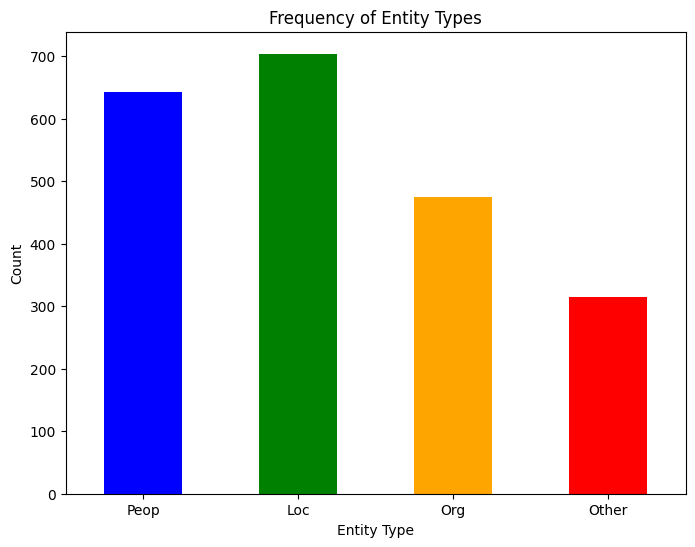

In [16]:
entity_counts = encoded_ent[['Peop', 'Loc', 'Org', 'Other']].sum()

plt.figure(figsize=(8, 6))
entity_counts.plot(kind='bar', color=['blue', 'green', 'orange', 'red'])
plt.title('Frequency of Entity Types')
plt.xlabel('Entity Type')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

#### Triplets

In [17]:
def create_triplets(relations, named_entities):
    triplets = []
    for relation in relations:
        head_idx = relation['head']
        tail_idx = relation['tail']
        rel_type = relation['type']

        head_entity_str = named_entities[head_idx]
        tail_entity_str = named_entities[tail_idx]

        head_text = head_entity_str.split(' (', 1)[0].strip()
        tail_text = tail_entity_str.split(' (', 1)[0].strip()

        triplet = f"{head_text}|{rel_type}|{tail_text}"
        triplets.append(triplet)
    return triplets

In [18]:
df_train['triplets'] = df_train.apply(lambda row: create_triplets(row['relations'], row['named_entities']), axis=1)
df_train

,entities,tokens,relations,orig_id,texts,named_entities,triplets
0,"[{'end': 5, 'start': 4, 'type': 'Loc'}, {'end'...","[Newspaper, `, Explains, ', U.S., Interests, S...","[{'head': 2, 'tail': 1, 'type': 'OrgBased_In'}]",3255,Newspaper ` Explains ' U.S. Interests Section ...,"[U.S. (4, 5) : Loc, Havana (9, 10) : Loc, Radi...",[Radio Reloj Network|OrgBased_In|Havana]
1,"[{'end': 26, 'start': 22, 'type': 'Other'}, {'...","[`, `, If, it, does, not, snow, ,, and, a, lot...","[{'head': 3, 'tail': 4, 'type': 'Work_For'}]",95,"` ` If it does not snow , and a lot , within t...","[150 , 000 hectares (22, 26) : Other, 370 , 50...",[Bruno Pusterla|Work_For|Italian Agricultural ...
2,"[{'end': 21, 'start': 19, 'type': 'Other'}, {'...","[The, self-propelled, rig, Avco, 5, was, heade...","[{'head': 2, 'tail': 1, 'type': 'Located_In'}]",2447,The self-propelled rig Avco 5 was headed to sh...,"[20 miles (19, 21) : Other, Louisiana (23, 24)...",[Morgan City|Located_In|Louisiana]
3,"[{'end': 2, 'start': 0, 'type': 'Peop'}, {'end...","[Annie, Oakley, ,, also, known, as, Little, Mi...","[{'head': 0, 'tail': 3, 'type': 'Live_In'}, {'...",5284,"Annie Oakley , also known as Little Miss Sure ...","[Annie Oakley (0, 2) : Peop, Little Miss Sure ...","[Annie Oakley|Live_In|Willowdell , Darke Count..."
4,"[{'end': 1, 'start': 0, 'type': 'Peop'}, {'end...","[Penry, raped, Pamela, Moseley, Carpenter, on,...","[{'head': 3, 'tail': 4, 'type': 'Located_In'}]",210,Penry raped Pamela Moseley Carpenter on Oct. 1...,"[Penry (0, 1) : Peop, Pamela Moseley Carpenter...",[Livingston|Located_In|Texas]
...,...,...,...,...,...,...,...
917,"[{'end': 1, 'start': 0, 'type': 'Other'}, {'en...","[An-a-one, ,, an-a-two, ,, an-a-three, billion...","[{'head': 1, 'tail': 2, 'type': 'Live_In'}]",5423,"An-a-one , an-a-two , an-a-three billion ) Tax...","[An-a-one (0, 1) : Other, Lawrence Welk (18, 2...",[Lawrence Welk|Live_In|North Dakota]
918,"[{'end': 2, 'start': 1, 'type': 'Org'}, {'end'...","[Another, GE, employee, ,, attorney, Robert, C...","[{'head': 1, 'tail': 0, 'type': 'Work_For'}]",1269,"Another GE employee , attorney Robert C. Ander...","[GE (1, 2) : Org, Robert C. Anderson (5, 8) : ...",[Robert C. Anderson|Work_For|GE]
919,"[{'end': 9, 'start': 8, 'type': 'Loc'}, {'end'...","[(, Text, ), Following, the, conclusion, of, t...","[{'head': 1, 'tail': 2, 'type': 'Live_In'}, {'...",4136,( Text ) Following the conclusion of the Genev...,"[Geneva (8, 9) : Loc, Ejup Ganic (12, 14) : Pe...",[Ejup Ganic|Live_In|Federation of Bosnia-Herze...
920,"[{'end': 2, 'start': 0, 'type': 'Org'}, {'end'...","[Eaglebrook, East, opened, in, Middletown, in,...","[{'head': 0, 'tail': 1, 'type': 'OrgBased_In'}]",1452,Eaglebrook East opened in Middletown in April .,"[Eaglebrook East (0, 2) : Org, Middletown (4, ...",[Eaglebrook East|OrgBased_In|Middletown]


## LLM approach for NER task: BERT

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from torchcrf import CRF
import torch.nn as nn
import tqdm

Configuration from [here]():
* 12 stacked encoders (each layer contains Self-Attention и Feed-Forward Network)
* hidden size = 768 (the number of features of the
hidden state -- standart)
* 12 heads in the MultiHead attention layers
* input size = 128 (max len of seq per step was reduced for optimization)
* batch size = 17 (num of examples per step was reduced for optimization
* num of epochs = 10
- a **CRF layer** which allows to link the result obtained with the
appropriate class of the named entity


Initial params:
batch_size=2
epochs = 3

In [8]:
! pip install pytorch-crf

In [ ]:
MODEL = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(MODEL)
bert_model = BertModel.from_pretrained(MODEL)

# Params
NUM_TAGS = 9
BATCH_SIZE = 17
MAX_LEN = 128
EPOCHS = 10

tag2id = {
    "O": 0,
    "B-LOC": 1,
    "I-LOC": 2,
    "B-MISC": 3,
    "I-MISC": 4,
    "B-ORG": 5,
    "I-ORG": 6,
    "B-PER": 7,
    "I-PER": 8
}

class BERT_CRF_NER(nn.Module):
    def __init__(self, bert, num_tags):
        super().__init__()
        self.bert = bert
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(bert.config.hidden_size, num_tags)
        self.crf = CRF(num_tags, batch_first=True)

    def forward(self, input_ids, attention_mask, tags=None):
        emissions = self.bert(input_ids, attention_mask)[0]
        emissions = self.dropout(emissions)
        emissions = self.fc(emissions)

        if tags is not None:
            return -self.crf(emissions, tags, mask=attention_mask.bool())
        else:
            return self.crf.decode(emissions, mask=attention_mask.bool())